<a href="https://colab.research.google.com/github/dohyung-kim/ccri/blob/main/script/adm0/exposure_by_th_adm0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [13]:

data_dir = '/content/drive/MyDrive/CCRI_results_misc'
misc_dir = '/content/drive/MyDrive/misc'
# Step 1: Read the CSV file containing the ccri_score
ccri_score = pd.read_csv(os.path.join(data_dir,'p1_p2_avg_ccri.csv'))
unicef_region  = pd.read_csv(os.path.join(misc_dir,'UNICEF_PROG_REG_GLOBAL.csv'))
ccri_score = ccri_score.merge(unicef_region, left_on='ISO3', right_on='ISO3Code', how='left')

# Step 2: Read the CSV file for child population data
child_pop_sum = pd.read_csv(os.path.join(data_dir,'child_pop_sum_adm0.csv'))

# Step 3: Group the child population data by 'ISO3' and sum the values
child_pop_sum_grouped = child_pop_sum.groupby('ISO3', as_index=False)['child_population'].sum()

# Step 4: Merge the ccri_score DataFrame with the grouped child population data on 'ISO3'
ccri_score_pop = ccri_score.merge(child_pop_sum_grouped, on='ISO3', how='left')



# Step 5: Extract the ccri values and calculate statistics
ccri_values = ccri_score_pop['P1_P2_geometric_avg'].values

# Calculate mean, std, and percentiles
mean_ccri = np.nanmean(ccri_values)
std_ccri = np.nanstd(ccri_values)

mean_plus_1sd_ccri = mean_ccri + std_ccri
mean_plus_2sd_ccri = mean_ccri + 2 * std_ccri

percentile_75_ccri = np.nanpercentile(ccri_values, 75)
percentile_90_ccri = np.nanpercentile(ccri_values, 90)
percentile_95_ccri = np.nanpercentile(ccri_values, 95)
percentile_99_ccri = np.nanpercentile(ccri_values, 99)

# Step 6: Identify ISO3 values with higher CCRI scores than each threshold
threshold_groups = {
    'mean': ccri_score_pop[ccri_score_pop['P1_P2_geometric_avg'] > mean_ccri],
    'mean_plus_1sd': ccri_score_pop[ccri_score_pop['P1_P2_geometric_avg'] > mean_plus_1sd_ccri],
    'percentile_75': ccri_score_pop[ccri_score_pop['P1_P2_geometric_avg'] > percentile_75_ccri],
    'percentile_90': ccri_score_pop[ccri_score_pop['P1_P2_geometric_avg'] > percentile_90_ccri],
}

# Group by Region and sum child population for each threshold
region_child_pop_by_threshold = {
    key: df.groupby('Region', as_index=False)['child_population'].sum()
    for key, df in threshold_groups.items()
}


In [15]:
region_child_pop_by_threshold

{'mean':                             Region  child_population
 0            East Asia and Pacific      4.766130e+08
 1      Eastern and Southern Africa      2.750307e+08
 2          Europe and Central Asia      5.591041e+07
 3  Latin America and the Caribbean      1.720397e+08
 4     Middle East and North Africa      1.732367e+08
 5                       South Asia      6.329178e+08
 6          West and Central Africa      3.044237e+08,
 'mean_plus_1sd':                             Region  child_population
 0            East Asia and Pacific      1.467958e+08
 1      Eastern and Southern Africa      1.790183e+08
 2  Latin America and the Caribbean      3.996496e+03
 3     Middle East and North Africa      2.546751e+07
 4                       South Asia      1.287188e+08
 5          West and Central Africa      2.859526e+08,
 'percentile_75':                             Region  child_population
 0            East Asia and Pacific      4.623443e+08
 1      Eastern and Southern Africa   

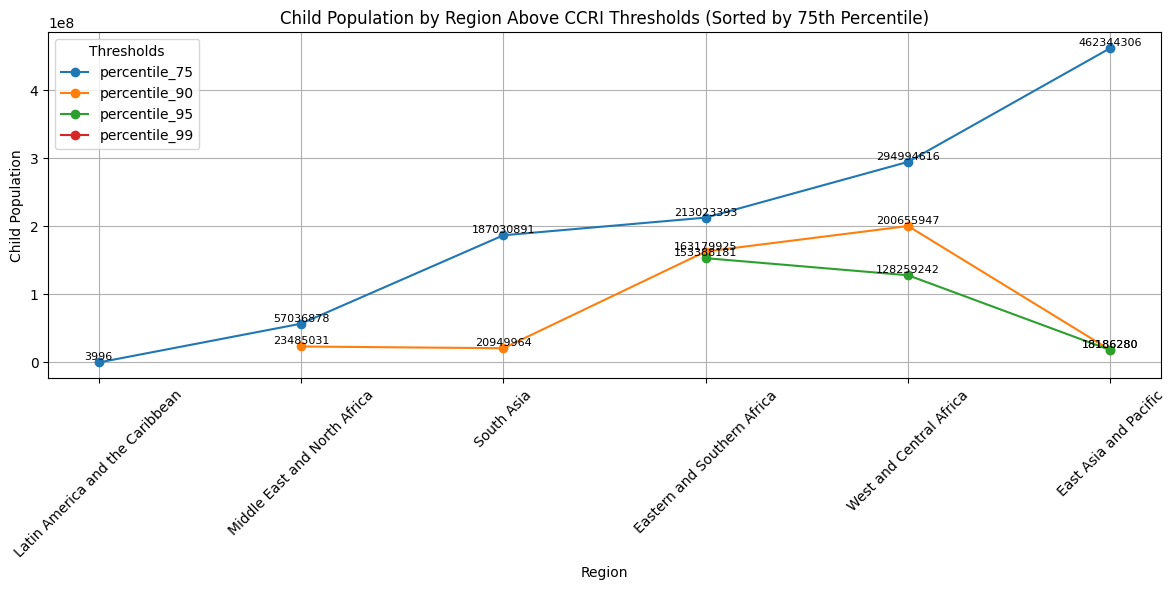

In [4]:
# Sort regions by child population in the 'percentile_75' threshold
sorted_regions = region_child_pop_by_threshold['percentile_75'].sort_values(
    'child_population', ascending=True
)['Region'].tolist()

# Replot with labels showing child population at each point (safely handling NaNs)
fig, ax = plt.subplots(figsize=(12, 6))

for key, df in region_child_pop_by_threshold.items():
    df_sorted = df.set_index('Region').reindex(sorted_regions).reset_index()
    ax.plot(df_sorted['Region'], df_sorted['child_population'], marker='o', label=key)

    # Add text labels for each point
    for i, row in df_sorted.iterrows():
        value = row['child_population']
        if pd.notna(value):
            ax.text(row['Region'], value + 2, f"{int(value)}",
                    ha='center', va='bottom', fontsize=8, rotation=0)

ax.set_title("Child Population by Region Above CCRI Thresholds (Sorted by 75th Percentile)")
ax.set_ylabel("Child Population")
ax.set_xlabel("Region")
ax.legend(title="Thresholds")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)

plt.show()




In [5]:
df_75 = threshold_groups['percentile_75'][['Country', 'Region', 'child_population','P1_P2_geometric_avg']].copy()


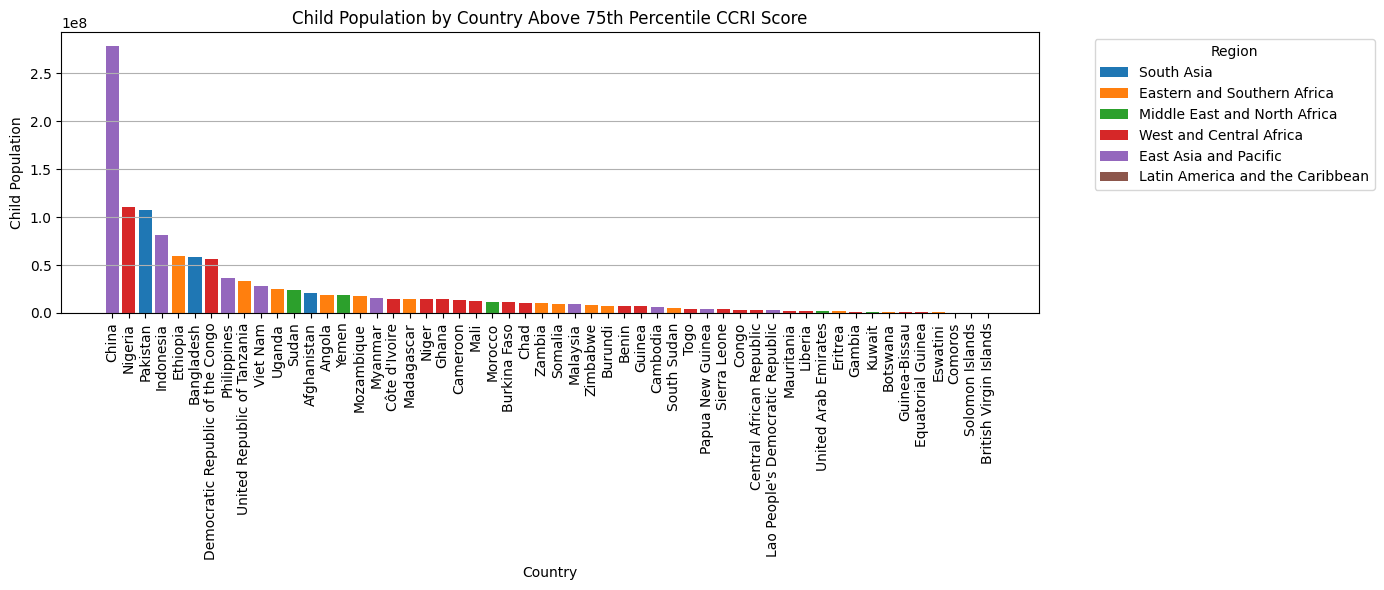

In [9]:
import matplotlib.colors as mcolors

# Use a more aesthetically pleasing color palette
fancy_palette = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
unique_regions = df_75['Region'].dropna().unique()

# Assign distinct fancy colors to regions
fancy_region_colors = {
    region: fancy_palette[i % len(fancy_palette)] for i, region in enumerate(unique_regions)
}

# Apply to the cleaned DataFrame
df_75_sorted = df_75.sort_values(by='child_population', ascending=False)
df_75_cleaned = df_75_sorted.dropna(subset=['Country']).copy()
df_75_cleaned['Country'] = df_75_cleaned['Country'].astype(str)
colors = df_75_cleaned['Region'].map(fancy_region_colors).fillna('gray')

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(df_75_cleaned['Country'], df_75_cleaned['child_population'], color=colors)


# Updated legend with fancy colors
legend_elements = [Patch(facecolor=color, label=region) for region, color in fancy_region_colors.items()]
ax.legend(handles=legend_elements, title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("Child Population by Country Above 75th Percentile CCRI Score")
ax.set_ylabel("Child Population")
ax.set_xlabel("Country")
ax.grid(True, axis='y')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


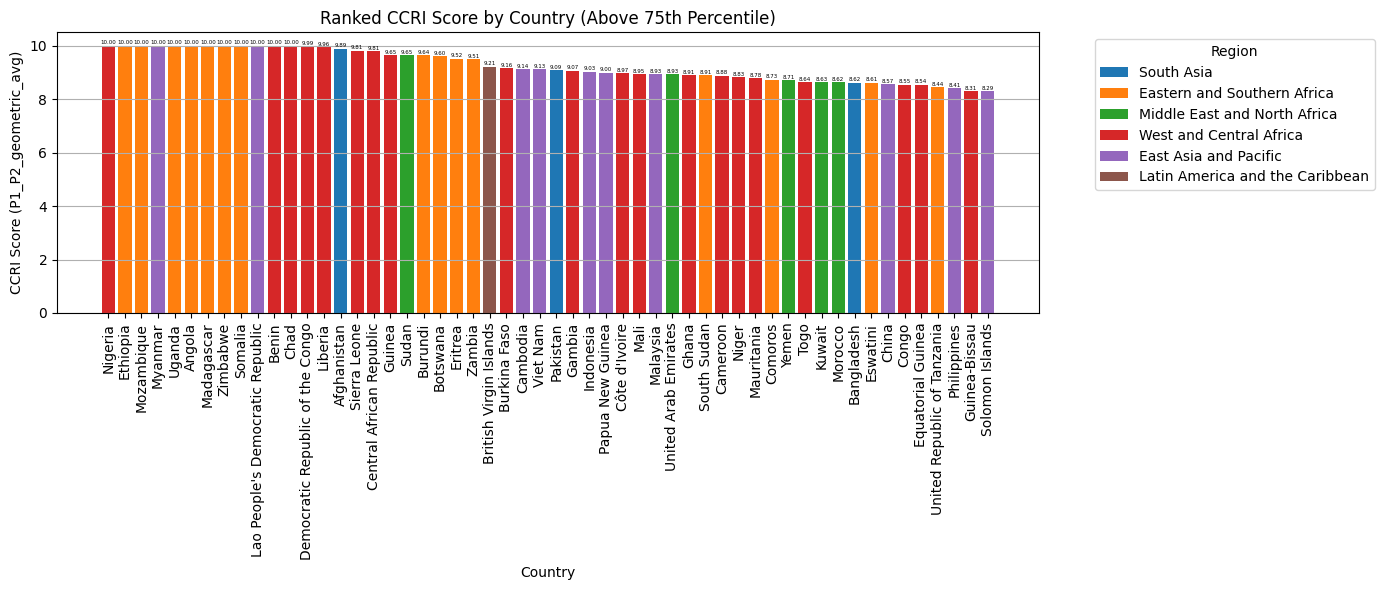

In [10]:
# Sort by CCRI score
df_ccri_sorted = df_75_cleaned.sort_values(by='P1_P2_geometric_avg', ascending=False)

# Map colors again for consistency
colors = df_ccri_sorted['Region'].map(fancy_region_colors).fillna('gray')

# Plot ranked by CCRI Score
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(df_ccri_sorted['Country'], df_ccri_sorted['P1_P2_geometric_avg'], color=colors)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}",
            ha='center', va='bottom', fontsize=4)

# Updated legend
legend_elements = [Patch(facecolor=color, label=region) for region, color in fancy_region_colors.items()]
ax.legend(handles=legend_elements, title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("Ranked CCRI Score by Country (Above 75th Percentile)")
ax.set_ylabel("CCRI Score (P1_P2_geometric_avg)")
ax.set_xlabel("Country")
ax.grid(True, axis='y')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [19]:
# Define a function to process scores and return grouped results
def compute_threshold_group_pop(df, score_col, label_prefix):
    values = df[score_col].values

    # Calculate thresholds
    mean_val = np.nanmean(values)
    std_val = np.nanstd(values)
    p75 = np.nanpercentile(values, 75)
    p90 = np.nanpercentile(values, 90)

    # Create filtered DataFrames
    groups = {
        f'{label_prefix}_mean': df[df[score_col] > mean_val],
        f'{label_prefix}_mean_plus_1sd': df[df[score_col] > mean_val + std_val],
        f'{label_prefix}_percentile_75': df[df[score_col] > p75],
        f'{label_prefix}_percentile_90': df[df[score_col] > p90]
    }

    # Group by Region and sum child population
    grouped = {
        key: gdf.groupby('Region', as_index=False)['child_population'].sum().rename(
            columns={'child_population': key}
        )
        for key, gdf in groups.items()
    }

    return grouped

# Compute grouped results for all three scores
ccri_groups = compute_threshold_group_pop(ccri_score_pop, 'P1_P2_geometric_avg', 'CCRI')
p1_groups = compute_threshold_group_pop(ccri_score_pop, 'P1_geometric_avg', 'P1_Hazard')
p2_groups = compute_threshold_group_pop(ccri_score_pop, 'P2_arithmetic_avg', 'P2_Vulnerability')

# Merge all group results into a single DataFrame on 'Region'
from functools import reduce

# Combine all dicts
all_group_dfs = {**ccri_groups, **p1_groups, **p2_groups}
merged_df = reduce(lambda left, right: pd.merge(left, right, on='Region', how='outer'), all_group_dfs.values())

# Fill NaNs with 0 (optional)
merged_df = merged_df.fillna(0)

total_row = merged_df.drop(columns='Region').sum(numeric_only=True)
total_row['Region'] = 'Total'
# Append to the DataFrame
merged_df = pd.concat([merged_df, pd.DataFrame([total_row])], ignore_index=True)

# Export to CSV
data_dir = '/content/drive/MyDrive/CCRI_results_misc'
output_path = os.path.join(data_dir, 'child_pop_by_thresholds_unicef_region.csv')
merged_df.to_csv(output_path, index=False)

print(f"Exported combined threshold child population data to: {output_path}")


Exported combined threshold child population data to: /content/drive/MyDrive/CCRI_results_misc/child_pop_by_thresholds_unicef_region.csv


In [20]:
merged_df

,Region,CCRI_mean,CCRI_mean_plus_1sd,CCRI_percentile_75,CCRI_percentile_90,P1_Hazard_mean,P1_Hazard_mean_plus_1sd,P1_Hazard_percentile_75,P1_Hazard_percentile_90,P2_Vulnerability_mean,P2_Vulnerability_mean_plus_1sd,P2_Vulnerability_percentile_75,P2_Vulnerability_percentile_90
0,East Asia and Pacific,4.766130e+08,1.467958e+08,4.623443e+08,1.818628e+07,4.721573e+08,4.197062e+08,4.258986e+08,3.786860e+08,4.633967e+08,3.906163e+06,3.744548e+07,3.797025e+06
1,Eastern and Southern Africa,2.750307e+08,1.790183e+08,2.130234e+08,1.631799e+08,2.271141e+08,1.358562e+08,1.723347e+08,1.344108e+08,2.562939e+08,1.529410e+08,1.977010e+08,1.274898e+08
2,Europe and Central Asia,5.591041e+07,0.000000e+00,0.000000e+00,0.000000e+00,5.805351e+07,1.283494e+07,1.928395e+07,1.283494e+07,3.972067e+06,0.000000e+00,0.000000e+00,0.000000e+00
3,Latin America and the Caribbean,1.720397e+08,3.996496e+03,3.996496e+03,0.000000e+00,1.495025e+08,3.940158e+07,4.833022e+07,0.000000e+00,4.258814e+07,6.608458e+06,1.355340e+07,1.285992e+04
4,Middle East and North Africa,1.732367e+08,2.546751e+07,5.703688e+07,2.348503e+07,1.667172e+08,4.411797e+07,1.023813e+08,1.972036e+07,7.749591e+07,4.279261e+07,4.519604e+07,4.238986e+07
5,South Asia,6.329178e+08,1.287188e+08,1.870309e+08,2.094996e+07,6.267778e+08,5.831214e+07,5.831214e+07,5.831214e+07,6.269929e+08,2.116512e+07,1.289339e+08,2.094996e+07
6,West and Central Africa,3.044237e+08,2.859526e+08,2.949946e+08,2.006559e+08,2.675370e+08,1.213470e+08,2.024101e+08,1.213470e+08,3.042783e+08,2.764709e+08,2.846706e+08,2.363785e+08
7,Total,2.090172e+09,7.659570e+08,1.214434e+09,4.264571e+08,1.967859e+09,8.315760e+08,1.028951e+09,7.253112e+08,1.775018e+09,5.038842e+08,7.075004e+08,4.310180e+08


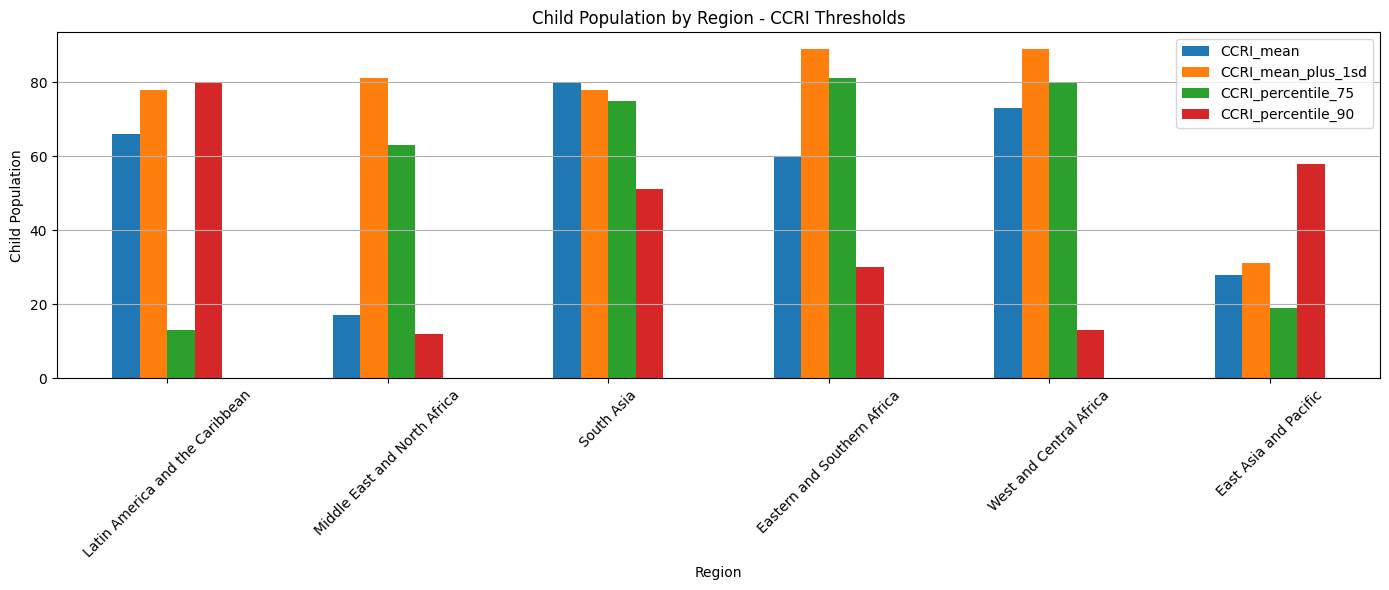

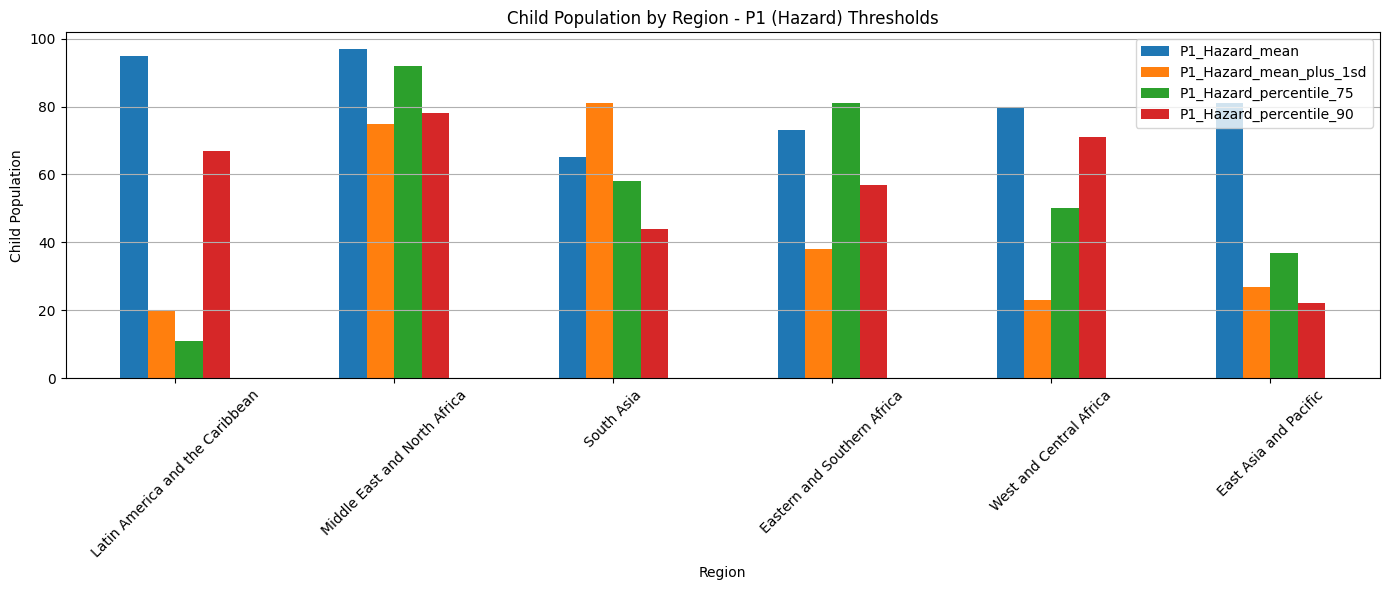

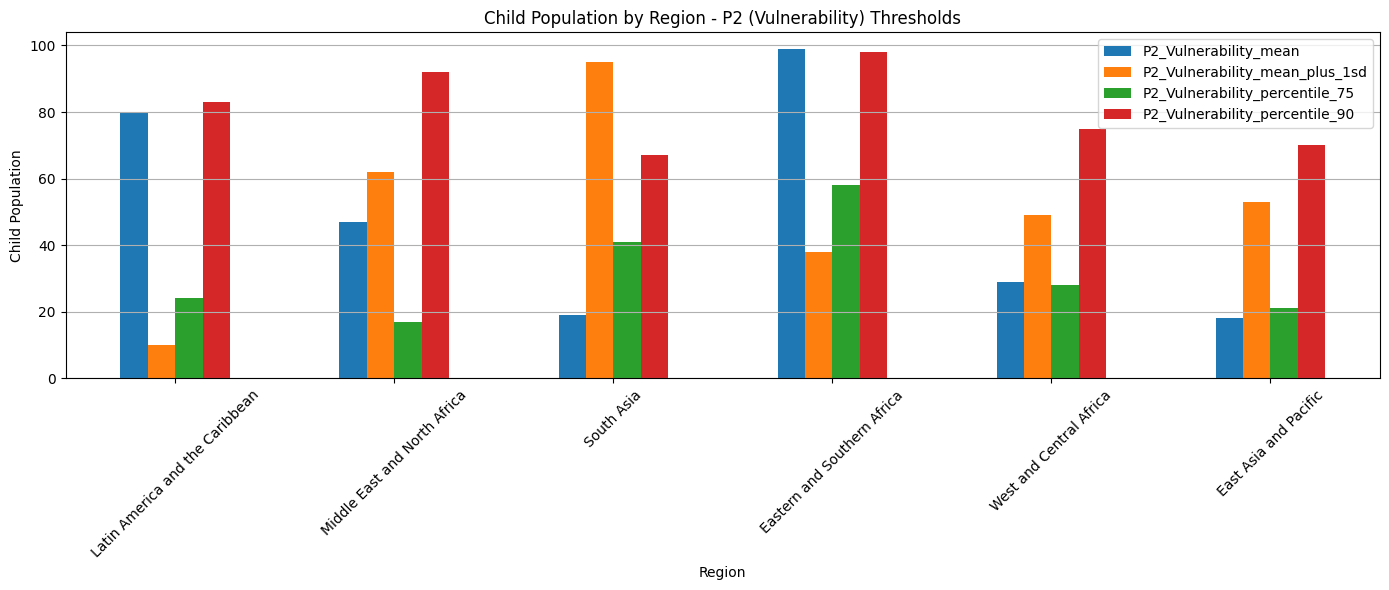

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate merged_df structure for demo (since we can't load the real CSV file)
# Assume the structure is one row per Region and columns for different thresholds from CCRI, P1, and P2
regions = [
    'Latin America and the Caribbean', 'Middle East and North Africa',
    'South Asia', 'Eastern and Southern Africa',
    'West and Central Africa', 'East Asia and Pacific'
]

merged_df = pd.DataFrame({
    'Region': regions,
    'CCRI_mean': np.random.randint(10, 100, len(regions)),
    'CCRI_mean_plus_1sd': np.random.randint(10, 100, len(regions)),
    'CCRI_percentile_75': np.random.randint(10, 100, len(regions)),
    'CCRI_percentile_90': np.random.randint(10, 100, len(regions)),
    'P1_Hazard_mean': np.random.randint(10, 100, len(regions)),
    'P1_Hazard_mean_plus_1sd': np.random.randint(10, 100, len(regions)),
    'P1_Hazard_percentile_75': np.random.randint(10, 100, len(regions)),
    'P1_Hazard_percentile_90': np.random.randint(10, 100, len(regions)),
    'P2_Vulnerability_mean': np.random.randint(10, 100, len(regions)),
    'P2_Vulnerability_mean_plus_1sd': np.random.randint(10, 100, len(regions)),
    'P2_Vulnerability_percentile_75': np.random.randint(10, 100, len(regions)),
    'P2_Vulnerability_percentile_90': np.random.randint(10, 100, len(regions)),
})

# Set Region as index
merged_df.set_index('Region', inplace=True)

# Plot CCRI thresholds
merged_df[[col for col in merged_df.columns if col.startswith('CCRI')]].plot(
    kind='bar', figsize=(14, 6), title='Child Population Exposure by Region - CCRI Thresholds'
)
plt.ylabel('Child Population')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot P1 (Hazard) thresholds
merged_df[[col for col in merged_df.columns if col.startswith('P1_Hazard')]].plot(
    kind='bar', figsize=(14, 6), title='Child Population Exposure by Region - P1 (Hazard) Thresholds'
)
plt.ylabel('Child Population')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot P2 (Vulnerability) thresholds
merged_df[[col for col in merged_df.columns if col.startswith('P2_Vulnerability')]].plot(
    kind='bar', figsize=(14, 6), title='Child Population Exposure by Region - P2 (Vulnerability) Thresholds'
)
plt.ylabel('Child Population')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
